* The following code is used to create the demo pictures. The directories include:
1) sample-hr: Store the target of SSIM and PSNR. It is 300*300 high resolution picture.
2) sample: It is the picture used to create bounding box and classification. 
3) output: ./dataset/results/demo/


In [1]:
import os
import math
import random
import argparse
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from IPython.display import display
import os.path as osp
import torch.utils.data as data

from time import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as T

from __future__ import print_function
from dbpn import Net as DBPN
from dbpn import get_eval_set
from dbpn import get_pair_set
from ssd import SSD
from ssd import build_ssd
from ssd.layers.modules import MultiBoxLoss
from ssd.data.config import voc
from ssd.data import detection_collate
from ssd.data import VOCAnnotationTransform, VOCDetection, BaseTransform, SRDetection
from torchcv.models.ssd import SSDBoxCoder
import cv2
from metric import *
import matplotlib.pyplot as plt
%matplotlib inline

import sys

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET
    
import sys; sys.argv=['']; del sys

# clean up device
torch.cuda.empty_cache()

In [2]:
# Arguments & settings
parser = argparse.ArgumentParser(description='PyTorch Super Resolution Detection Networks')
parser.add_argument('--upscale_factor', type=int, default=4, help="super resolution upscale factor")
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--batch_size', type=int, default=1, help='training batch size') # GPU: 9GB!
parser.add_argument('--threads', type=int, default=1, help='number of threads for data loading')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--gpu_mode', type=bool, default=True)
parser.add_argument('--gpus', default=1, type=float, help='number of gpu')
parser.add_argument('--test_dataset', type=str, default='VOC12-LR-X8-test')
#parser.add_argument('--sr_dataset', type=str, default='VOC12-SR-X8')
parser.add_argument('--eval_dataset', type=str, default='./dataset/samples/SR-SROD')
parser.add_argument('--train_dataset', type=str, default='./dataset/samples/SR-SROD')
parser.add_argument('--hr_dataset', type=str, default='./dataset/samples/HR300')
parser.add_argument('--anno_path', type=str, default='Annotations')
parser.add_argument('--imSetpath', type=str, default='ImageSets')
parser.add_argument('--input_dir', type=str, default='./dataset')
parser.add_argument('--output', default='./dataset/results/bbox', help='Location to save some outputs')
parser.add_argument('--checkpt', default='./checkpoint', help='Location to save checkpoint models')
parser.add_argument('--lr', type=float, default=1e-4, help='Learning Rate. Default=0.0001')
parser.add_argument('--nEpochs', type=int, default=5, help='number of epochs to fine tune net S over target loss')

opt = parser.parse_args()

gpus_list=range(opt.gpus)
print(opt)

cuda = opt.gpu_mode
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)
if cuda:
    torch.cuda.manual_seed(opt.seed)
    torch.cuda.empty_cache()


Namespace(anno_path='Annotations', batch_size=1, checkpt='./checkpoint', eval_dataset='./dataset/samples/HR300', gpu_mode=True, gpus=1, hr_dataset='./dataset/samples/HR300', imSetpath='ImageSets', input_dir='./dataset', lr=0.0001, nEpochs=5, output='./dataset/results/bbox', seed=123, testBatchSize=1, test_dataset='VOC12-LR-X8-test', threads=1, train_dataset='./dataset/samples/HR300', upscale_factor=4)


In [3]:
class SRload(data.Dataset):
    """Super Resolution VOC Detection Dataset Object

    simple data loader to S+D networks, no input transform
    assume: input => 300x300 / 4: 75x75
    input is image, target is annotation

    returns:
        lr_image, hr_image, targets (annotation), height, width (original)
    """

    def __init__(self, root='../../dataset', image_sets='demo.txt',
                 data_mean=(104,117,123), target_transform=VOCAnnotationTransform()):
        super(SRload, self).__init__()
        self.image_set = image_sets
        self.target_transform = target_transform
        self._annopath = osp.join('%s', 'Annotations', '%s.xml')
        self._image_lr = osp.join('%s', 'samples/SR-SROD', '%s.jpg')
        #self._image_sr = osp.join('%s', 'VOC12-SR-x4', '%s.jpg')
        self._image_hr = osp.join('%s', 'samples/HR300', '%s.jpg')
        self._img_orig = osp.join('%s', 'samples/HR', '%s.jpg')
        self._img_mean = np.array(data_mean, dtype=np.float32)
        self.ids = list()
        rootpath = root
        for line in open(osp.join(rootpath, image_sets)):
            self.ids.append((rootpath, line.strip()))

    def __getitem__(self, index):
        im, imo, gt, h, w = self.pull_item(index)

        return im, imo, gt

    def __len__(self):
        return len(self.ids)

    def pull_item(self, index):
        img_id = self.ids[index]

        target = ET.parse(self._annopath % img_id).getroot()
        img_lr = cv2.imread(self._image_lr % img_id).astype(np.float32)
        # img_lr -= self._img_mean (same with dbpn SR training, no -mean)
        #img_lr /= 255.           # (SR net expect input range [0.0, 1.0])
        # img_hr is ground truth for net SR
        img_hr = cv2.imread(self._image_hr % img_id).astype(np.float32)
        # img_hr -= self._img_mean
        # imag_O is the original HR image, read to get origal H/W
        imag_O = cv2.imread(self._img_orig % img_id)
        height, width, channels = imag_O.shape

        if self.target_transform is not None:
            # target is list of bbox in percentage x/y coordinate
            target = self.target_transform(target, width, height)

        target = np.array(target)
        boxes, labels = target[:, :4], target[:, 4]
        # to rgb
        img_lr = img_lr[:, :, (2, 1, 0)]
        img_hr = img_hr[:, :, (2, 1, 0)]
        # img = img.transpose(2, 0, 1)
        target = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        # return torch.from_numpy(img), target, height, width
        # return torch.from_numpy(img_lr).permute(2, 0, 1), torch.from_numpy(img_hr).permute(2, 0, 1), torch.from_numpy(target), height, width
        return torch.from_numpy(img_lr).permute(2, 0, 1), torch.from_numpy(img_hr).permute(2, 0, 1), target, height, width

    def pull_image(self, index):
        '''Returns the original image object at index in PIL form

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to show
        Return:
            PIL img
        '''
        img_id = self.ids[index]
        return cv2.imread(self._image_lr % img_id, cv2.IMREAD_COLOR), cv2.imread(self._image_hr % img_id, cv2.IMREAD_COLOR)


In [4]:
print('===> Loading net S fine-tune training datasets')

# VOC0712 dataset mean
MEANS = (104, 117, 123)

sd_dataset = SRload(root='./dataset', image_sets='demo.txt', data_mean = MEANS,
                         target_transform = VOCAnnotationTransform())

sd_data_loader = DataLoader(dataset=sd_dataset, batch_size=opt.batch_size, num_workers=opt.threads,
                            shuffle=False, collate_fn=detection_collate, pin_memory=True)


===> Loading net S fine-tune training datasets


In [5]:
# TODO:
# 1. come up with test/eval functions
# 2. come up with visualization image

class DBPN2SSD(nn.Module):
    
    def __init__(self, s_model_name, d_model_name, d_frozen):
        super(DBPN2SSD, self).__init__()
        self.supervis = DBPN(num_channels=3, base_filter=64, feat=256, num_stages=7, scale_factor=4)
        if os.path.exists(s_model_name):
            self.supervis = torch.nn.DataParallel(self.supervis, device_ids=gpus_list)
            self.supervis.load_state_dict(torch.load(s_model_name, map_location=lambda storage, loc: storage))

        # self.detector = SSD(), setup ssd as 'train' mode for gradient flow
        # later at test/eval situation, we will overwrite it's mode to 'test'
        self.detector = build_ssd('test', 300, 21)
        if os.path.exists(d_model_name):
            self.detector.load_state_dict(torch.load(d_model_name, map_location=lambda storage, loc: storage))
        if d_frozen:
            for param in self.detector.parameters():
                param.requires_grad = False
            for param in self.supervis.parameters():
                param.requires_grad = False
                
        
    def forward(self, x):
        superx = self.supervis(x)
        sr = superx
        # current detector: SSD300, so assume superx: 300x300!
        detect = self.detector(superx)
        return (sr, detect)


    

In [6]:

type_image = 'SROD'

labelmap = (  # always index 0
    'plane', 'bike', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'table', 'dog', 'horse',
    'm-bike', 'person', 'plant',
    'sheep', 'sofa', 'train', 'tv')

COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
FONT = cv2.FONT_HERSHEY_SIMPLEX

def save_img(img, img_name):
    #save_img = img.squeeze().clamp(0, 1).numpy().transpose(1,2,0)

    # save img
    save_dir=os.path.join(opt.output,'SR-SROD')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_fn = save_dir +'/'+ img_name
    cv2.imwrite(save_fn, cv2.cvtColor(img, cv2.COLOR_BGR2RGB),  [cv2.IMWRITE_PNG_COMPRESSION, 0])

    
def eval():

    net = DBPN2SSD('dbpn/models/VOC12-LR-x4-DBPN-ep100.pth', 'ssd/weights/ssd300_mAP_77.43_v2.pth', True)
    net.eval()
    
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []


    for iteration, batch in enumerate(sd_data_loader, 1):
        
        # input is LR image; sr_target is pseudo (300x300) original HR image, det_target is bboxes
        # input, sr_target = batch[0], batch[1]
        input, sr_target, det_target = batch[0], batch[1], batch[2]

        if cuda:
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
            #net.supervis = torch.nn.DataParallel(net.supervis)
            cudnn.benchmark = True
            net = net.cuda(gpus_list[0])
        if cuda:
            input_v = Variable(input.cuda(gpus_list[0]))
            sr_target_v = Variable(sr_target.cuda(gpus_list[0]))
            det_target = [Variable(ann.cuda(gpus_list[0]), volatile=True) for ann in det_target]
        else:
            input_v = Variable(input)
            sr_target_v = Variable(sr_target)
            det_target = [Variable(ann, volatile=True) for ann in det_target]

        ssd_out = net.detector(input_v)
 
        target = sr_target.squeeze().numpy().transpose(1,2,0)
        input_img = input.squeeze().numpy().transpose(1,2,0)
        ssim = metric_ssim(target,input_img)
        psnr = metric_psnr(target,input_img)

        # Get the target box and lables
        print("ssim, psnr",ssim,psnr)

        im_target = input.squeeze().numpy().transpose(1,2,0)
        im_target = np.clip(im_target, 0, 255)

        
        detections = ssd_out.data
        # scale each detection back up to the image
        scale = torch.Tensor([300, 300,300,300])
        pred_num = 0
        for i in range(detections.size(1)):
            j = 0
            #print("%.4f" % detections[0, i, j, 0])
            while detections[0, i, j, 0] >= 0.6:
                score = detections[0, i, j, 0]
                label_name = labelmap[i-1]
                pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
                coords = (pt[0], pt[1], pt[2], pt[3])
                print("coords",coords,score,label_name)
                
                cv2.rectangle(im_target, (pt[0], pt[1]), (pt[2], pt[3]), COLORS[i % 3], 1)
                cv2.putText(im_target, label_name, (int(pt[0]), int(pt[1])-4),
                            FONT, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
                pred_num += 1
                j += 1
                

        plt.imshow(im_target.astype(np.uint8))
        plt.show()
        if math.isnan(psnr):
            psnr = 0
        if math.isnan(ssim):
            ssim = 0        
        save_img(im_target,"%s-%d-%.4f-%.4f.jpg" %(type_image,iteration,ssim,psnr))


/home/shared/cs231x/super-resolution-detection/dbpn/dbpn.py:47: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/home/shared/cs231x/super-resolution-detection/dbpn/dbpn.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/home/shared/cs231x/super-resolution-detection/ssd/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/home/shared/cs231x/super-resolution-detection/ssd/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)
__main__:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


ssim, psnr 0 0
coords (-3.28812, 118.52161, 289.63638, 231.667) tensor(0.9988) plane


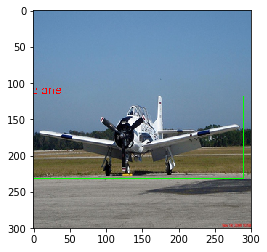

ssim, psnr 0 0
coords (175.31073, 157.38687, 195.92796, 180.82053) tensor(0.6548) car


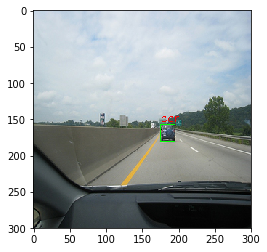

ssim, psnr 0 0
coords (151.15428, 111.520996, 266.0139, 223.97562) tensor(0.9997) car


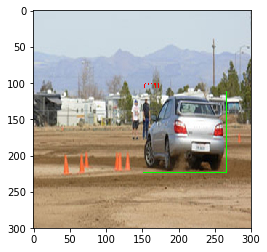

ssim, psnr 0 0
coords (6.102334, 148.6658, 88.98434, 195.9084) tensor(0.9615) boat
coords (78.764946, 187.9043, 205.74976, 287.7026) tensor(0.9994) m-bike
coords (171.97754, 154.68393, 209.93263, 248.2543) tensor(0.9746) person


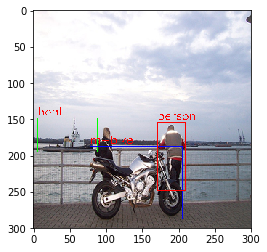

ssim, psnr 0 0
coords (202.82793, 150.3057, 297.25397, 284.91168) tensor(0.9953) boat


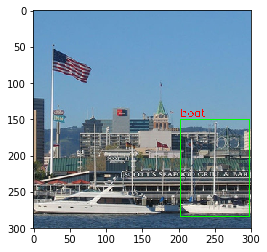

ssim, psnr 0 0
coords (56.22168, 214.90706, 120.37666, 269.51422) tensor(0.9682) boat
coords (144.47145, 184.04045, 206.28394, 265.4695) tensor(0.9169) boat
coords (16.222095, 152.16321, 62.68486, 270.82965) tensor(0.9902) person
coords (180.37448, 90.002625, 262.4675, 268.37973) tensor(0.9860) person
coords (146.74248, 126.632095, 191.07202, 238.39166) tensor(0.9623) person


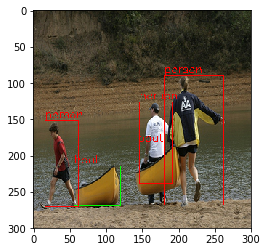

ssim, psnr 0 0
coords (45.398327, 79.4613, 149.8569, 187.52124) tensor(0.8965) car
coords (188.51746, 86.24649, 224.18661, 188.09871) tensor(0.9615) person


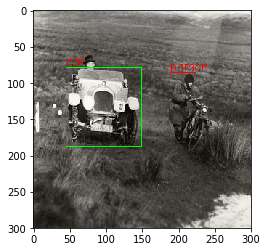

ssim, psnr 0 0
coords (128.06161, 34.96511, 290.95245, 161.41121) tensor(0.9831) plane
coords (21.464645, 24.571537, 300.64386, 247.85837) tensor(0.9701) plane
coords (50.855644, 84.82497, 135.68086, 153.81677) tensor(0.9128) plane
coords (2.29638, 214.29646, 57.71646, 277.02084) tensor(0.9721) car


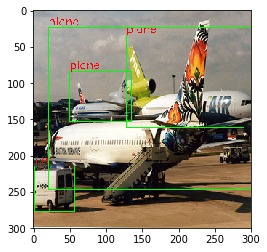

ssim, psnr 0 0
coords (63.008907, 243.82614, 110.793434, 274.52985) tensor(0.9325) car
coords (114.669655, 261.27975, 168.68828, 293.86105) tensor(0.9089) car


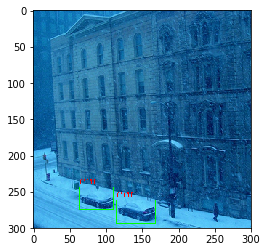

ssim, psnr 0 0
coords (137.36795, 115.49879, 270.60535, 263.23428) tensor(0.9769) m-bike
coords (155.1109, 89.725685, 294.09042, 227.17313) tensor(0.9822) person


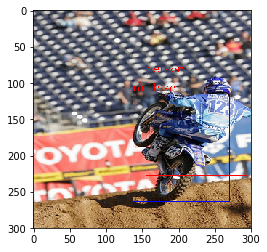

ssim, psnr 0 0
coords (143.43393, 126.798416, 188.40941, 177.51178) tensor(0.9889) horse
coords (149.43842, 108.45044, 183.84697, 158.93468) tensor(0.9307) person


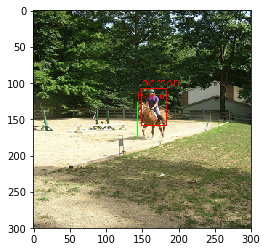

ssim, psnr 0 0
coords (3.4573317, 38.23945, 298.67786, 302.78708) tensor(0.9979) person
coords (264.52222, 1.1895776, 298.3867, 80.74128) tensor(0.9753) person
coords (58.216488, 7.317207, 77.754074, 44.20411) tensor(0.9267) person
coords (43.685642, 7.947209, 62.7484, 42.07524) tensor(0.8077) person


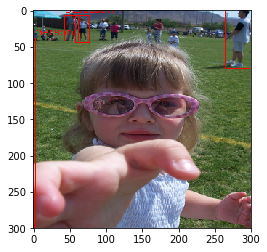

In [7]:
eval()
    


In [8]:
torch.cuda.empty_cache()
